# wav2vec2 implementation


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:334: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:334: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- STAGE 1: Freezing base model and training classifier head ---


Stage 1 - Epoch 1/3:   0%|          | 0/452 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Stage 1 - Epoch 1/3: 100%|██████████| 452/452 [10:02<00:00,  1.33s/it]


Stage 1 - Epoch 1 | Train Loss: 1.0397 | Val Loss: 1.0711 | Val Acc: 0.2636


Stage 1 - Epoch 2/3: 100%|██████████| 452/452 [08:43<00:00,  1.16s/it]


Stage 1 - Epoch 2 | Train Loss: 0.9850 | Val Loss: 1.0369 | Val Acc: 0.3333


Stage 1 - Epoch 3/3: 100%|██████████| 452/452 [08:41<00:00,  1.15s/it]


Stage 1 - Epoch 3 | Train Loss: 0.9581 | Val Loss: 1.0141 | Val Acc: 0.3592

--- STAGE 2: Unfreezing all layers and fine-tuning the entire model ---


Stage 2 - Epoch 1/6: 100%|██████████| 452/452 [11:36<00:00,  1.54s/it]


Stage 2 - Epoch 1 | Train Loss: 0.7478 | Val Loss: 0.5390 | Val Acc: 0.7726


Stage 2 - Epoch 2/6: 100%|██████████| 452/452 [11:36<00:00,  1.54s/it]


Stage 2 - Epoch 2 | Train Loss: 0.4384 | Val Loss: 0.3384 | Val Acc: 0.8508


Stage 2 - Epoch 3/6: 100%|██████████| 452/452 [11:37<00:00,  1.54s/it]


Stage 2 - Epoch 3 | Train Loss: 0.2649 | Val Loss: 0.2939 | Val Acc: 0.8740


Stage 2 - Epoch 4/6: 100%|██████████| 452/452 [11:36<00:00,  1.54s/it]


Stage 2 - Epoch 4 | Train Loss: 0.1440 | Val Loss: 0.2910 | Val Acc: 0.8760


Stage 2 - Epoch 5/6: 100%|██████████| 452/452 [11:36<00:00,  1.54s/it]


Stage 2 - Epoch 5 | Train Loss: 0.0806 | Val Loss: 0.3455 | Val Acc: 0.9083


Stage 2 - Epoch 6/6: 100%|██████████| 452/452 [11:36<00:00,  1.54s/it]


Stage 2 - Epoch 6 | Train Loss: 0.0342 | Val Loss: 0.3781 | Val Acc: 0.9050

--- Evaluating the final fine-tuned Wav2Vec2 model ---


Evaluating on Test Set: 100%|██████████| 97/97 [00:51<00:00,  1.87it/s]



--- Final Wav2Vec2 Classification Report (2-Stage Training) ---
              precision    recall  f1-score   support

    negative       0.96      0.86      0.91       993
     neutral       0.70      0.96      0.81       250
    positive       0.83      0.87      0.85       306

    accuracy                           0.88      1549
   macro avg       0.83      0.89      0.85      1549
weighted avg       0.89      0.88      0.88      1549



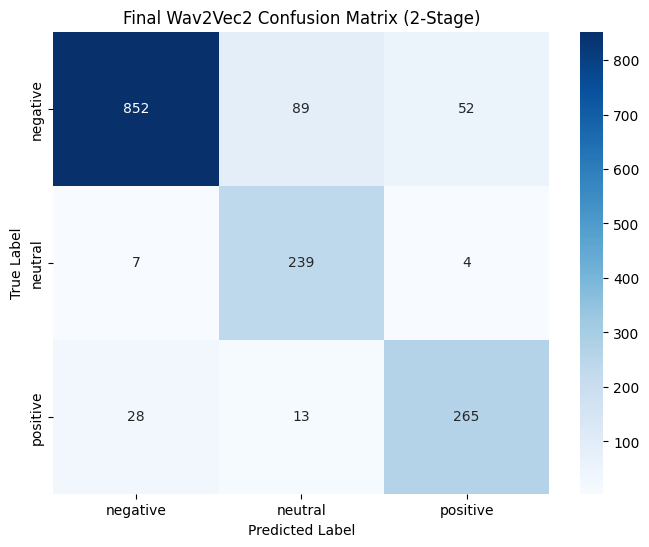

In [ ]:
# =============================================================================
# STEP 0: SETUP, LIBRARIES & DATA PREPARATION
# =============================================================================
# Install required libraries
!pip install transformers[torch] accelerate -q

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import kagglehub

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

## Data Loading and Preparation

This section downloads the RAVDESS and CREMA-D datasets using `kagglehub`. It then processes the metadata to create a DataFrame with file paths and sentiment labels, using a sentiment mapping to group related emotions.

In [ ]:
# --- Download & Process Datasets ---
RAVDESS_PATH = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
CREMA_D_PATH = kagglehub.dataset_download("ejlok1/cremad")

sentiment_map = {'happy': 'positive', 'surprised': 'positive', 'sad': 'negative', 'angry': 'negative', 'fearful': 'negative', 'disgust': 'negative', 'neutral': 'neutral', 'calm': 'neutral'}
ravdess_emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
ravdess_data = []
for dirpath, _, filenames in os.walk(RAVDESS_PATH):
    for filename in filenames:
        if filename.endswith('.wav'):
            emotion_code = filename.split('-')[2]; emotion = ravdess_emotion_map.get(emotion_code); sentiment = sentiment_map.get(emotion)
            if sentiment: ravdess_data.append({"filepath": os.path.join(dirpath, filename), "sentiment": sentiment})
ravdess_df = pd.DataFrame(ravdess_data)

crema_emotion_map = {'HAP': 'happy', 'SAD': 'sad', 'ANG': 'angry', 'FEA': 'fearful', 'DIS': 'disgust', 'NEU': 'neutral'}
crema_data = []
crema_audio_path = os.path.join(CREMA_D_PATH, "AudioWAV")
for filename in os.listdir(crema_audio_path):
    if filename.endswith('.wav'):
        emotion_code = filename.split('_')[2]; emotion = crema_emotion_map.get(emotion_code); sentiment = sentiment_map.get(emotion)
        if sentiment: crema_data.append({"filepath": os.path.join(crema_audio_path, filename), "sentiment": sentiment})
crema_df = pd.DataFrame(crema_data)

combined_df = pd.concat([ravdess_df, crema_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

## Wav2Vec2 Preparation and Dataset Class

This section loads the pre-trained Wav2Vec 2.0 feature extractor and defines the `AudioDataset` class. This class handles loading the audio files, resampling them to the target sampling rate, and processing them using the Wav2Vec 2.0 feature extractor. It also includes a `collate_fn` to handle potential errors during audio processing.

In [ ]:
# =============================================================================
# STEP 1: WAV2VEC2 PREPARATION
# =============================================================================
MODEL_CHECKPOINT = "facebook/wav2vec2-base"
TARGET_SAMPLING_RATE = 16000
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)

class AudioDataset(Dataset):
    def __init__(self, df, feature_extractor, max_duration_s=5.0):
        self.filepaths = df['filepath'].tolist(); self.labels = df['label'].tolist()
        self.feature_extractor = feature_extractor; self.max_length = int(max_duration_s * TARGET_SAMPLING_RATE)
    def __len__(self): return len(self.filepaths)
    def __getitem__(self, idx):
        filepath = self.filepaths[idx]; label = self.labels[idx]
        try:
            audio, sr = librosa.load(filepath, sr=None)
            if sr != TARGET_SAMPLING_RATE: audio = librosa.resample(y=audio, orig_sr=sr, target_sr=TARGET_SAMPLING_RATE)
            inputs = self.feature_extractor(audio, sampling_rate=TARGET_SAMPLING_RATE, max_length=self.max_length, truncation=True, padding='max_length', return_tensors="pt")
            input_values = inputs.input_values.squeeze(0)
        except Exception as e: print(f"Error processing {filepath}: {e}"); return None, None
        return input_values, label

le = LabelEncoder(); combined_df['label'] = le.fit_transform(combined_df['sentiment'])
X_train_df, X_temp_df = train_test_split(combined_df, test_size=0.3, random_state=42, stratify=combined_df['label'])
X_val_df, X_test_df = train_test_split(X_temp_df, test_size=0.5, random_state=42, stratify=X_temp_df['label'])
train_dataset = AudioDataset(X_train_df, feature_extractor); val_dataset = AudioDataset(X_val_df, feature_extractor); test_dataset = AudioDataset(X_test_df, feature_extractor)
def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None];
    if not batch: return None, None
    return torch.utils.data.dataloader.default_collate(batch)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

## Model and Training Setup

This section loads the pre-trained Wav2Vec 2.0 model for audio classification and sets up the loss function and optimizer. It also calculates class weights to handle the imbalanced dataset.

In [ ]:
# =============================================================================
# STEP 2: MODEL & TRAINING SETUP
# =============================================================================
NUM_CLASSES = len(le.classes_)
model = AutoModelForAudioClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=NUM_CLASSES).to(device)
class_weights_np = compute_class_weight('balanced', classes=np.unique(X_train_df['label']), y=X_train_df['label'])
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

## Two-Stage Fine-Tuning

This section implements a two-stage fine-tuning process for the Wav2Vec 2.0 model. In Stage 1, only the classification head is trained with the base model frozen. In Stage 2, all layers are unfrozen and the entire model is fine-tuned with a lower learning rate and a learning rate scheduler.

In [ ]:
# =============================================================================
# STEP 3: TWO-STAGE FINE-TUNING
# =============================================================================

# --- STAGE 1: Train only the classification head ---
print("\n--- STAGE 1: Freezing base model and training classifier head ---")
# Freeze the parameters of the base Wav2Vec2 model
for param in model.wav2vec2.parameters():
    param.requires_grad = False

# The optimizer will only update the weights of the unfrozen classifier head
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-3)
STAGE1_EPOCHS = 3

for epoch in range(STAGE1_EPOCHS):
    model.train(); train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Stage 1 - Epoch {epoch+1}/{STAGE1_EPOCHS}"):
        if inputs is None: continue
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(); outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward(); optimizer.step(); train_loss += loss.item()

    model.eval(); val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            if inputs is None: continue
            inputs, labels = inputs.to(device), labels.to(device); outputs = model(inputs)
            loss = criterion(outputs.logits, labels); val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1); val_total += labels.size(0); val_correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss/len(train_loader); avg_val_loss = val_loss/len(val_loader); val_acc = val_correct/val_total
    print(f"Stage 1 - Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

# --- STAGE 2: Unfreeze and fine-tune the entire model ---
print("\n--- STAGE 2: Unfreezing all layers and fine-tuning the entire model ---")
# Unfreeze all parameters
for param in model.parameters():
    param.requires_grad = True

# Create a new optimizer for the whole model with a lower learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
STAGE2_EPOCHS = 6 # Total epochs will be STAGE1 + STAGE2
num_training_steps = STAGE2_EPOCHS * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps)
lr_scheduler = get_scheduler("linear", optimizer, num_warmup_steps, num_training_steps)
best_val_loss = float('inf')

for epoch in range(STAGE2_EPOCHS):
    model.train(); train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Stage 2 - Epoch {epoch+1}/{STAGE2_EPOCHS}"):
        if inputs is None: continue
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(); outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward(); optimizer.step(); lr_scheduler.step(); train_loss += loss.item()

    model.eval(); val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            if inputs is None: continue
            inputs, labels = inputs.to(device), labels.to(device); outputs = model(inputs)
            loss = criterion(outputs.logits, labels); val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1); val_total += labels.size(0); val_correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss/len(train_loader); avg_val_loss = val_loss/len(val_loader); val_acc = val_correct/val_total
    print(f"Stage 2 - Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_wav2vec2_model_2stage.pth')

## Model Evaluation

This section evaluates the final fine-tuned Wav2Vec 2.0 model on the hold-out test set. It loads the best model state dictionary, performs inference, and then displays the classification report and confusion matrix to assess the model's performance.

In [ ]:
# =============================================================================
# STEP 4: EVALUATE THE FINAL MODEL
# =============================================================================
print("\n--- Evaluating the final fine-tuned Wav2Vec2 model ---")
model.load_state_dict(torch.load('best_wav2vec2_model_2stage.pth'))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        if inputs is None: continue
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n--- Final Wav2Vec2 Classification Report (2-Stage Training) ---")
print(classification_report(all_labels, all_preds, target_names=le.classes_))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Final Wav2Vec2 Confusion Matrix (2-Stage)'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.show()